In [28]:
import math
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange
from einops import rearrange
import os
import cv2
import matplotlib.pyplot as plt

#original module
from loadData import Dataset
import mae 
import cosine_scheduler as sche
import evaluation_reconstruction as eva

In [15]:
## シード値の設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

# Preprocess

## load data

In [18]:
SRC_TRAIN=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\train_IR1000_B500_S100.csv"
SRC_TEST=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\test_IR1000_B500_S100.csv"
#SRC_TRAIN=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\train.csv"
#SRC_TEST=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\test.csv"

SCALE_X = 243/240
SCALE_Y = 243/240
IMG_SIZE = 240

dataset = Dataset(scale_x = SCALE_X,scale_y = SCALE_Y,img_size=IMG_SIZE,src_train=SRC_TRAIN,src_test=SRC_TEST)
img_train = dataset.img_train
label_train = dataset.label_train
img_valid = dataset.img_valid
label_valid = dataset.label_valid
img_test = dataset.img_test
label_test = dataset.label_test

[[1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20230823\\IR1000_B500_S100\\36\\concat_MAE_spatterframe_estimation\\196.jpg']
 [1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20230823\\IR1000_B500_S100\\42\\concat_MAE_spatterframe_estimation\\404.jpg']]
spatter label : : train : 19/19, valid : 1/1 test : 2/2
length of dataset is  19
image data shape :  (19, 243, 243)
length of dataset is  1
image data shape :  (1, 243, 243)
length of dataset is  2
image data shape :  (2, 243, 243)


## make dataloader

In [19]:
batch_size = 1

train_dl = torch.utils.data.DataLoader(
    img_train,
    batch_size=batch_size,
)

valid_dl = torch.utils.data.DataLoader(
    img_valid,
    batch_size=batch_size,
)
test_dl = torch.utils.data.DataLoader(
    img_test,
    batch_size=2#batch_size,
)


## load MAE model 

### Hyperparameters

### for 27*27patches

In [20]:
# ハイパーパラメータの設定

config = {
    "image_size": [243, 243], # original image size
    "patch_size": [9, 9], #size of 1 patch :: [height, width], default :: if 27*27 patches -> [9,9], 81*81 patches -> [3,3]
    "emb_dim": 128,#embedding dimensions :: vector dimension per 1 patch
    "enc_layers": 12, #encoder :: number of dense layers
    "enc_heads": 2,# encoder :: number of attention heads :: enc_heads*enc_dim_head = enc_mlp_dim
    "enc_dim_head": 64,#encoder :: attention head dimension :: default = 64
    "enc_mlp_dim": 128,#encoder :: dimension of multiple perceptron layers(= dense layer) default :: 192,
    "dec_layers": 4, # number of dense layers in decoder
    "dec_heads": 2,# number of attention heads :: dec_heads * dec_dim_head = dec_mlp_dim seems to be good equation
    "dec_dim_head": 64, #decoder attention head dimension :: default = 64
    "dec_mlp_dim":128,#decoder dimenstion of multiple layer perceptron :: default = 128
    "numPatches":27,#number of patches :: 27 or 81
    "mask_ratio": 1/9, #mask ratio :: how much ratio is masked to a image :: default -> only last frame(spatter frame) is masked
    "dropout": 0. #dense layer :: dropout rate
}

### for 81*81patches

In [38]:

config = {
    "image_size": [243, 243], # original image size
    "patch_size": [3, 3], #size of 1 patch :: [height, width], default :: if 27*27 patches -> [9,9], 81*81 patches -> [3,3]
    "emb_dim": 27,#embedding dimensions :: vector dimension per 1 patch
    "enc_layers": 4, #encoder :: number of dense layers
    "enc_heads": 3,# encoder :: number of attention heads :: enc_heads*enc_dim_head = enc_mlp_dim
    "enc_dim_head": 9,#encoder :: attention head dimension :: default = 64
    "enc_mlp_dim": 27,#encoder :: dimension of multiple perceptron layers(= dense layer) default :: 192,
    "dec_layers": 4, # number of dense layers in decoder
    "dec_heads": 3,# number of attention heads :: dec_heads * dec_dim_head = dec_mlp_dim seems to be good equation
    "dec_dim_head": 9, #decoder attention head dimension :: default = 64
    "dec_mlp_dim":27,#decoder dimenstion of multiple layer perceptron :: default = 128
    "numPatches":81,#number of patches :: 27 or 81
    "mask_ratio": 1/9, #mask ratio :: how much ratio is masked to a image :: default -> only last frame(spatter frame) is masked
    "dropout": 0. #dense layer :: dropout rate
}

In [39]:
# モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = mae.MAE_ViT(**config).to(device)

cuda


# Trainer of MAE

## train setting

In [40]:
epochs = 1000
lr = 0.01
warmup_length = 30
step_count = 0
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
lr_plan = sche.CosineScheduler(epochs, lr, warmup_length=warmup_length)

SaveDir = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit"

In [41]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [42]:
losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    # スケジューラで学習率を更新する
    new_lr = lr_plan(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_valid_loss = 0.

    # モデルの訓練
    for x in train_dl:
        step_count += 1
        model.train()
        x = x.to(device)

        rec_img, mask = model(x)
        train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]
        train_loss.backward()

        if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            optimizer.step()
            optimizer.zero_grad()

        total_train_loss += train_loss.item()
    losses.append(total_train_loss)

    # モデルの評価
    with torch.no_grad():
        for x in valid_dl:
            model.eval()

            with torch.no_grad():
                x = x.to(device)

                rec_img, mask = model(x)
                valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                total_valid_loss += valid_loss.item()
    val_losses.append(total_valid_loss)


    print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(train_dl):.4f} Valid Loss: {total_valid_loss/len(valid_dl):.4f}")
    if epoch % 500 == 499:
        # モデルを保存しておく
        torch.save(model.state_dict(), os.path.join(SaveDir,"mae_speed100_patch{patch}_emb{emb}_enc{layers}layers_{epoch}.pth".format(patch=config["numPatches"],emb=config["emb_dim"],layers=config["enc_layers"],epoch=epoch+1)))

Epoch[1 / 1000] Train Loss: 0.7273 Valid Loss: 0.5263
Epoch[2 / 1000] Train Loss: 0.3578 Valid Loss: 0.2610
Epoch[3 / 1000] Train Loss: 0.1551 Valid Loss: 0.0925
Epoch[4 / 1000] Train Loss: 0.0554 Valid Loss: 0.0638
Epoch[5 / 1000] Train Loss: 0.0619 Valid Loss: 0.0787
Epoch[6 / 1000] Train Loss: 0.0680 Valid Loss: 0.1050
Epoch[7 / 1000] Train Loss: 0.0647 Valid Loss: 0.0571
Epoch[8 / 1000] Train Loss: 0.0401 Valid Loss: 0.0546
Epoch[9 / 1000] Train Loss: 0.0412 Valid Loss: 0.0653
Epoch[10 / 1000] Train Loss: 0.0497 Valid Loss: 0.0598
Epoch[11 / 1000] Train Loss: 0.0341 Valid Loss: 0.0442
Epoch[12 / 1000] Train Loss: 0.0294 Valid Loss: 0.0478
Epoch[13 / 1000] Train Loss: 0.0334 Valid Loss: 0.0490
Epoch[14 / 1000] Train Loss: 0.0285 Valid Loss: 0.0388
Epoch[15 / 1000] Train Loss: 0.0236 Valid Loss: 0.0377
Epoch[16 / 1000] Train Loss: 0.0240 Valid Loss: 0.0336
Epoch[17 / 1000] Train Loss: 0.0202 Valid Loss: 0.0247
Epoch[18 / 1000] Train Loss: 0.0165 Valid Loss: 0.0214
Epoch[19 / 1000] Tr

## loss plot

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_35560\178518234.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


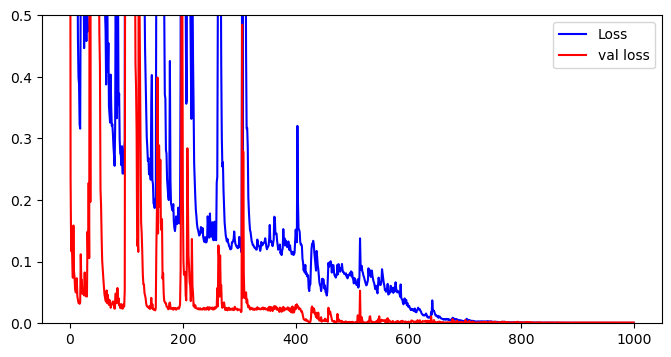

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(losses,color="b",label="Loss")
ax.plot(val_losses,color="r",label="val loss")
ax.set_ylim(0,0.5)
ax.legend()
fig.show()

# Postprocess

## load model

In [7]:
NUM_EPOCH=1000
speed=100
patch=config["numPatches"]
emb_dim = config["emb_dim"]
enc_layer=config["enc_layers"]

modelPath = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_speed{speed}_patch{patch}_emb{emb_dim}_enc{enc_layer}layers_{epoch}.pth".format(speed=speed,patch=patch,emb_dim=emb_dim,enc_layer=enc_layer,epoch=NUM_EPOCH)

model = mae.MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(modelPath, map_location=device))

model.eval()
x = next(iter(test_dl))
with torch.no_grad():
    rec_img, mask = model(x.to(device))

x, rec_img, mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

63.0
(6561,)
1's imgs mean difference : 18.5, std : 62.5

72.5
(6561,)
2's imgs mean difference : 8.0, std : 38.2

average difference : 13.2, average std : 50.4



c:\Users\Furukawa\Documents\TechAssistant\code_kawawaki\MLmodel\evaluation_reconstruction.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


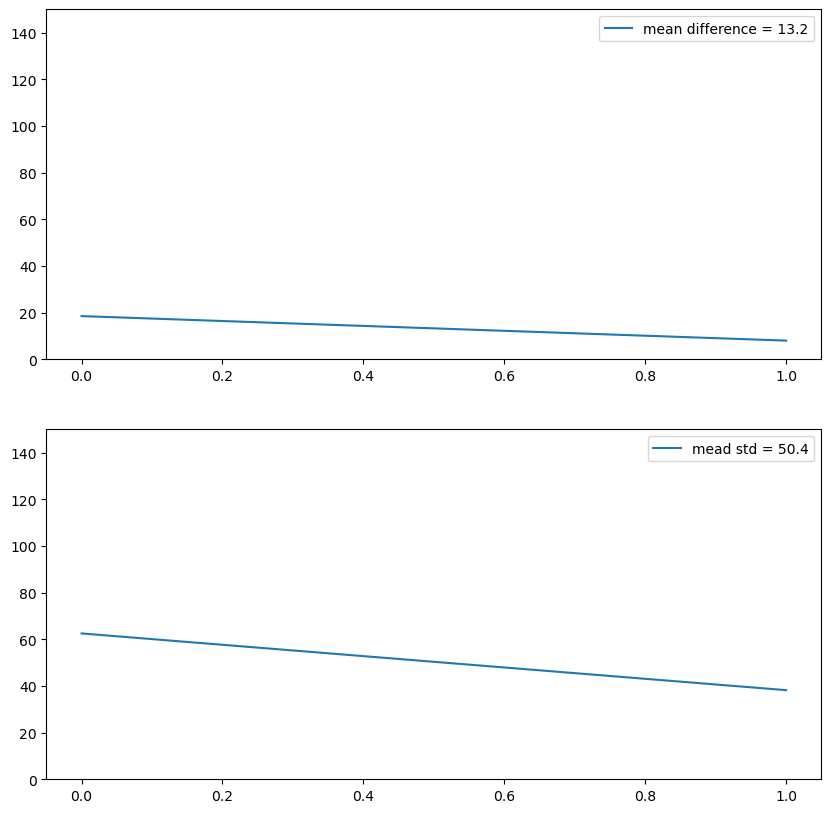

In [13]:
saveDir = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\mae\patches{patch}\emb{emb_dim}_IR1000_B500_S{speed}".format(patch=patch,emb_dim=emb_dim,speed=speed)
evaluation = eva.EvaluateFrameEstimation(batch_size=2,test_dl=test_dl,model=model,pretrainedModel=modelPath,device=device,saveDir=saveDir,maskThreshold=60,graphYmax=150, debug=True)

## Visualize AttentionMap

In [11]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    print(img.shape)
    img = np.array(img)
    img = img.transpose(1,2,0) #[Channel, H,W] -> [H,W,Channel]
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0,1)), 0, 1) #gray scale
    img = np.clip(img,0,1)
    ax = fig.add_subplot(4, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((243, 243, 2))), axis=2)
        ax = fig.add_subplot(4, 3, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)


torch.Size([1, 243, 243])


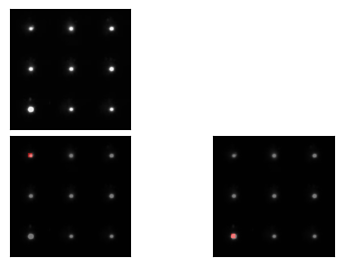

In [12]:
#preTrainedModel = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_patch27_27_emb128_enc12layers_1000.pth"
#model = mae.MAE_ViT(**config).to(device)
#model.load_state_dict(torch.load(preTrainedModel), map_location=device)
model.eval()
for _ in range(1):
    x= next(iter(test_dl))  # 検証用データからデータを取得する

display_attn_map(model, x)

# Visition Transformer :: Classifier

## load ViT dataset

In [ ]:
SRC_TRAIN=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\train_IR1000_B500_S200.csv"
SRC_TEST=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\test_IR1000_B500_S200.csv"
#SRC_TRAIN=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\train.csv"
#SRC_TEST=r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\test.csv"

SCALE_X = 243/240
SCALE_Y = 243/240
IMG_SIZE = 240

dataset = Dataset(scale_x = SCALE_X,scale_y = SCALE_Y,img_size=IMG_SIZE,src_train=SRC_TRAIN,src_test=SRC_TEST)
img_train = dataset.img_train
label_train = dataset.label_train
img_valid = dataset.img_valid
label_valid = dataset.label_valid
img_test = dataset.img_test
label_test = dataset.label_test

In [ ]:
WIDTH =int(IMG_SIZE * SCALE_X)
HEIGHT = int(IMG_SIZE * SCALE_Y)

class Process(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train,width = WIDTH, height = HEIGHT):
        self.x_train = x_train#.reshape(-1,1,width,height)#.astype('float32') / 255
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

train_data = Process(img_train, label_train)
valid_data = Process(img_valid, label_valid)
test_data = Process(img_test,label_test)

In [ ]:
BATCH_SIZE = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Hyperparameters setting 
    - same as MAE model

### 27*27 patches

In [ ]:
config = {
    "image_size": [243, 243], # original image size
    "patch_size": [9, 9], #size of 1 patch :: [height, width], default :: if 27*27 patches -> [9,9], 81*81 patches -> [3,3]
    "emb_dim": 128,#embedding dimensions :: vector dimension per 1 patch
    "enc_layers": 12, #encoder :: number of dense layers
    "enc_heads": 2,# encoder :: number of attention heads :: enc_heads*enc_dim_head = enc_mlp_dim
    "enc_dim_head": 64,#encoder :: attention head dimension :: default = 64
    "enc_mlp_dim": 128,#encoder :: dimension of multiple perceptron layers(= dense layer) default :: 192,
    "dec_layers": 4, # number of dense layers in decoder
    "dec_heads": 2,# number of attention heads :: dec_heads * dec_dim_head = dec_mlp_dim seems to be good equation
    "dec_dim_head": 64, #decoder attention head dimension :: default = 64
    "dec_mlp_dim":128,#decoder dimenstion of multiple layer perceptron :: default = 128
    "numPatches":27,#number of patches :: 27 or 81
    "mask_ratio": 1/9, #mask ratio :: how much ratio is masked to a image :: default -> only last frame(spatter frame) is masked
    "dropout": 0. #dense layer :: dropout rate
}

### for 81*81patches

In [ ]:
config = {
    "image_size": [243, 243], # original image size
    "patch_size": [3, 3], #size of 1 patch :: [height, width], default :: if 27*27 patches -> [9,9], 81*81 patches -> [3,3]
    "emb_dim": 27,#embedding dimensions :: vector dimension per 1 patch
    "enc_layers": 4, #encoder :: number of dense layers
    "enc_heads": 3,# encoder :: number of attention heads :: enc_heads*enc_dim_head = enc_mlp_dim
    "enc_dim_head": 9,#encoder :: attention head dimension :: default = 64
    "enc_mlp_dim": 27,#encoder :: dimension of multiple perceptron layers(= dense layer) default :: 192,
    "dec_layers": 4, # number of dense layers in decoder
    "dec_heads": 3,# number of attention heads :: dec_heads * dec_dim_head = dec_mlp_dim seems to be good equation
    "dec_dim_head": 9, #decoder attention head dimension :: default = 64
    "dec_mlp_dim":27,#decoder dimenstion of multiple layer perceptron :: default = 128
    "numPatches":81,#number of patches :: 27 or 81
    "mask_ratio": 1/9, #mask ratio :: how much ratio is masked to a image :: default -> only last frame(spatter frame) is masked
    "dropout": 0. #dense layer :: dropout rate
}

In [ ]:
modelPath=r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\mae\patches{patch}\emb{emb_dim}_IR1000_B500_S{speed}".format(patch=patch,emb_dim=emb_dim,speed=speed)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pretrained_MAE = mae.MAE_ViT(**config).to(device)
pretrained_MAE.load_state_dict(torch.load(modelPath, map_location=device))

encoder = pretrained_MAE.encoder #mae.encoder#pretrained_model.encoder

# モデルの定義
model = mae.ViT_Classifier(encoder).to(device)

## Trainer

### learning setting

In [ ]:
epochs = 1000
lr = 0.01#0.0005
warmup_length = 100
batch_size = 64
optimizer = optim.AdamW(model.head.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)  # 分類器部分のみ学習
lr_plan = sche.CosineScheduler(epochs, lr, warmup_length)
criterion = nn.CrossEntropyLoss()

saveDir = r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit"

### Train

In [ ]:
step_count = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []
for epoch in range(epochs):
    new_lr = lr_plan(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.
    for x, t in dataloader_train:
        step_count += 1
        x, t = x.to(device), t.to(device)
        pred = model(x)

        train_loss = criterion(pred, t)
        train_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        total_train_acc += train_acc
    losses.append(total_train_loss/len(dataloader_train))
    accuracies.append(total_train_acc/len(dataloader_train))

    with torch.no_grad():
        for x, t in dataloader_valid:
            x, t = x.to(device), t.to(device)
            pred = model(x)

            valid_loss = criterion(pred, t)
            valid_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc
    val_losses.append(total_valid_loss/len(dataloader_valid))
    val_accuracies.append(total_valid_acc/len(dataloader_valid))
    print(f"Epoch[{epoch+1} / {epochs}]",
          f"Train Loss: {total_train_loss/len(dataloader_train):.4f}",
          f"Train Acc.: {total_train_acc/len(dataloader_train):.4f}",
          f"Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}",
          f"Valid Acc.: {total_valid_acc/len(dataloader_valid):.4f}")

    if epoch %200 == 199:
        torch.save(model.state_dict(), os.path.join(saveDir,"vit_patch{patch}_emb{emb_dim}_enc{layers}layers_epoch{epoch}.pth".format(patch=config["numPatches"],emb=config["emb_dim"],layers=config["enc_layers"],epoch+1)))

## Plot Loss&Accuracy

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(losses,color="b",label="Loss")
ax[0].plot(val_losses,color="r",label="val loss")
#ax[0].set_ylim(0,0.7)
ax[0].legend()
ax[1].plot(accuracies,color="b",label="accuracy")
ax[1].plot(val_accuracies,color="r",label="val accuracy")
#ax[1].set_ylim(0,0.7)
ax[1].legend()
fig.show()

## Evaluate with TestData

In [ ]:
total_test_loss = 0.
total_test_acc = 0.
total_spatter_pred = 0
total_spatter_label = 0
true_pred = 0
true_label = 0
with torch.no_grad():
    for x, t in dataloader_test:
        x, t = x.to(device), t.to(device)
        pred = model(x)
        test_loss = criterion(pred, t)
        #print(torch.argmax(pred, dim=1)[0])
        #print(t[0]==torch.argmax(pred, dim=1)[0])
        #predict spatter:
        if torch.argmax(pred,dim=1)[0] == 1:
            if t[0] == 0:
                total_spatter_pred += 1
            elif t[0] == 1:
                total_spatter_pred += 1
                total_spatter_label += 1
                true_pred += 1
        #predict non spatter
        else:
            #false negative
            if t[0] == 1:
                total_spatter_label += 1
        #if torch.arg
        test_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()
        total_test_loss += test_loss.item()
        total_test_acc += test_acc

precision = ((true_pred)/total_spatter_pred)
recall = ((true_pred)/total_spatter_label)
f1 = 2*precision*recall/(precision+recall)
print(f"Test Loss: {total_test_loss/len(dataloader_test):.4f}",f"Test Acc.: {total_test_acc/len(dataloader_test):.4f}",
      f"Test Precision : {precision:.4f}",f"Test Recall : {recall:.4f}",f"Test F-value : {f1:.4f}")

## Visualize Attention map

In [ ]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    img = np.clip(np.transpose(torch.squeeze(img).cpu().numpy(), (0,1)), 0, 1)
    ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((240, 240, 3))), axis=2)
        ax = fig.add_subplot(2, 3, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)

In [ ]:
#mae = MAE_ViT(**config).to(device)
#encoder = mae.encoder

# モデルの定義
#model = ViT_Classifier(encoder).to(device)
#model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture09/model/ViT_supervised_params.pth", map_location=device))
model.eval()
for i in range(100):
    if i %10 == 9:
        x,t = next(iter(dataloader_test))
        display_attn_map(model, x)